In [12]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import jax

from pulsedjax.simulate_trace import MakeTrace, apply_noise, GaussianAmplitude, PolynomialPhase, MultiPulse, RandomPhase

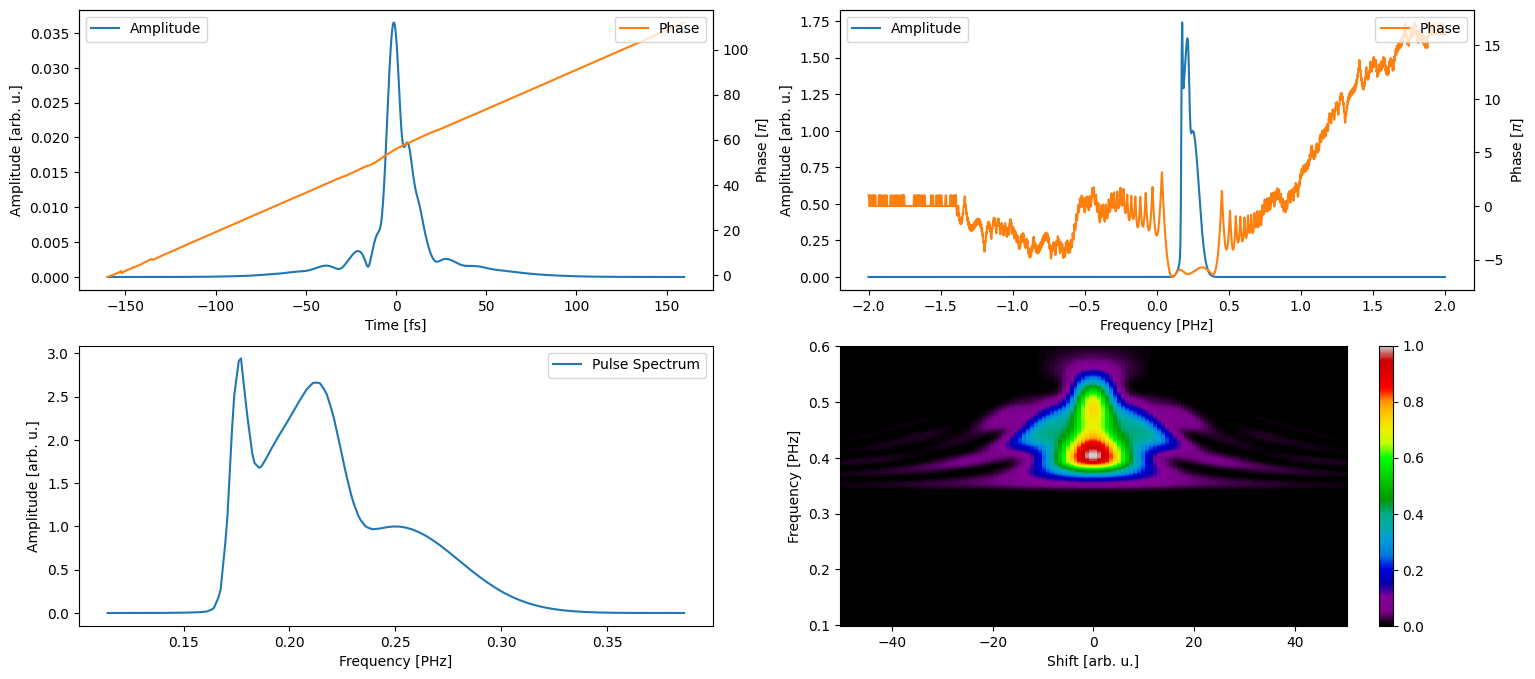

In [1]:
from pulsedjax.simulate_trace import MakeTrace
from pulsedjax.simulate_trace import GaussianAmplitude, RandomPhase
import jax.numpy as jnp

amp0 = GaussianAmplitude((1,1,1), (0.175,0.2,0.25), (0.01,0.05,0.1), (1,2,1))
phase0 = RandomPhase(number_of_points=4)

amp1 = GaussianAmplitude(1, 0.4, 0.05, 1)
phase1 = RandomPhase(number_of_points=4)


mp = MakeTrace(N=128*10, f_max=2)
time, pulse_t, frequency, pulse_f = mp.generate_pulse((amp0,phase0))

_, _, frequency_gate, pulse_f_gate = mp.generate_pulse((amp1,phase1))


# import refractiveindex
# parameters = refractiveindex.RefractiveIndexMaterial(shelf="main", book="SiO2", page="Malitson")
# z_arr = jnp.linspace(-5,5,128) 
# z_arr, frequency_trace, trace, spectra = mp.generate_chirpscan(time, frequency, pulse_t, pulse_f, "shg", 
#                                                                z_arr, phase_type="material", parameters=parameters,
#                                                                frequency_range=(0.1,0.65), N=128)



delay = jnp.linspace(-50,50,128) 
delay, frequency_trace, trace, spectra = mp.generate_frog(time, frequency, pulse_t, pulse_f, "shg", delay,
                                                               frequency_range=(0.1,0.6), N=128*2)
